In [19]:
from Bio import Entrez, SeqIO
from Bio.Seq import Seq

from Bio.SeqRecord import SeqRecord


import vcf
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import functools

import pysam
import pandas as pd
import numpy as np


Entrez.email = "simon.burgermeister@gmail.com"


## Install with:
<br>
conda install -c bioconda bwa
<br>

## Build index:
<br>
<br>

In [10]:
!bwa index sequences4/ref/ref_sequence.fasta

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index sequences4/ref/ref_sequence.fasta
[main] Real time: 0.014 sec; CPU: 0.011 sec


In [11]:
!bwa mem sequences4/ref/ref_sequence.fasta sequences4/all.fasta > sequences4/aln.sam 

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 11 sequences (327935 bp)...
[M::mem_process_seqs] Processed 11 reads in 0.273 CPU sec, 0.273 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem sequences4/ref/ref_sequence.fasta sequences4/all.fasta
[main] Real time: 0.275 sec; CPU: 0.274 sec


In [12]:
!samtools view -S -b sequences4/aln.sam > sequences4/aligned.bam
#!samtools view -1 sequences4/aln.sam > sequences3/aln.bam
!samtools sort sequences4/aligned.bam -o sequences4/sorted.bam
!samtools index sequences4/sorted.bam

In [13]:
!samtools mpileup -uf sequences4/ref/ref_sequence.fasta sequences4/sorted.bam | bcftools call -mv  --multiallelic-caller --variants-only  > sequences4/var.raw.vcf

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000


In [48]:
f = vcf.Reader(filename='sequences4/var.raw.vcf')

my_type = defaultdict(int)
num_alts = defaultdict(int)

mut_data=[]
for rec in f:
    #print(rec.var_type)
    #print(rec)
    my_type[rec.var_type, rec.var_subtype] += 1
    mut_data.append([rec.var_type, rec.POS])
    if rec.is_snp:
        num_alts[len(rec.ALT)] += 1
print(my_type)
#print(num_alts)
mut_df=pd.DataFrame(mut_data, columns=['type', 'position'])
mut_df.head()

defaultdict(<class 'int'>, {('snp', 'ts'): 21, ('snp', 'tv'): 15, ('indel', 'del'): 4})


,type,position
0,snp,241
1,snp,913
2,snp,1059
3,snp,2110
4,snp,3037


In [9]:
import re

#samfile = pysam.AlignmentFile("sequences/sorted.bam", "rb")
samfile = pysam.AlignmentFile("sequences4/aligned.bam", "rb")
jj=0


for read in samfile:
    read_seq=str(read.seq)
    
    tt=str(read)
    rr=tt.split('\t0\t0')
    read_ID=rr[0]
    
    cig=read.cigarstring
    #print(read.cigarstring)
        
    match = re.findall(r'(\d+)(\w)',cig)
    
    s_start=read.reference_start
    print(read_ID)
    print(read_seq[100-s_start:120-s_start])
    print(read.cigarstring)
    print(' ')
    
    

NC_045512.2
GGCTGCATGCTTAGTGCACT
29903M
 
MW911846.1
GGCTGCATGCTTAGTGCACT
11257M9D10468M6D220M3D6277M1D1588M
 
MW911847.1
GGCTGCATGCTTAGTGCACT
11257M9D10468M6D220M3D6277M1D1590M
 
MW911849.1
GGCTGCATGCTTAGTGCACT
11257M9D10468M6D220M3D6277M1D1590M
 
MW911850.1
GGCTGCATGCTTAGTGCACT
11256M9D10468M6D220M3D6277M1D1586M
 
MW911860.1
GGCTGCATGCTTAGTGCACT
11257M9D10468M6D220M3D6277M1D1586M
 
MW911870.1
GGCTGCATGCTTAGTGCACT
11257M9D10468M6D220M3D6277M1D1590M
 
MW912051.1
GGCTGCATGCTTAGTGCACT
11257M9D10468M6D220M3D6277M1D1590M
 
MW913363.1
GGCTGCATGCTTAGTGCACT
11233M9D10468M6D220M3D6277M1D1565M
 
MW593784.1
GGCTGCATGCTTAGTGCACT
29798M
 
MW593785.1
GGCTGCATGCTTAGTGCACT
29798M
 


## Info from Ref Seq:
<br>
<br>

In [40]:
ref_id='NC_045512'
Entrez.email='simon.burgermeister@gmail.com'

handle = Entrez.efetch(db='nucleotide', id=ref_id, rettype='gb')
record = SeqIO.read(handle, "genbank")
handle.close()
ref_seq_str=str(record.seq)

dic_map={}
dic_seq={}
ref_df=[]
for feat in record.features:
    #print(feat.type)
    if feat.type=='CDS': #'gene'
        #print(feat.qualifiers['gene'][0])
        if feat.qualifiers['gene'][0] not in dic_map.keys():
            dic_map[feat.qualifiers['gene'][0]]=[int(feat.location.start), int(feat.location.end)]

            prot_seq=feat.qualifiers['translation'][0]
            rna_seq=str(record.seq)[int(feat.location.start): int(feat.location.end)]
            dic_seq[feat.qualifiers['gene'][0]]=rna_seq
            cds_start=int(feat.location.start)
            cds_stop=int(feat.location.end)
            ref_df.append([feat.qualifiers['gene'][0], cds_start, cds_stop, cds_stop-cds_start])
        #break
   
    #Mature peptides:    
    elif feat.type=='mat_peptide':
        
        prod=feat.qualifiers['product']
        locus_tag=feat.qualifiers['locus_tag']
        protein_id=feat.qualifiers['protein_id']
        end=int(feat.location.end)
        start=int(feat.location.start)
        
    
    # Stem loops:
    elif feat.type=='stem_loop':
        end=int(feat.location.end)
        start=int(feat.location.start)
        
        function=feat.qualifiers['function'][0]
        #note=feat.qualifiers['note'][0]
        
    #5'UTR 3'UTR      
print(dic_map)
df_refs=pd.DataFrame(ref_df, columns=['gene', 'start', 'stop', 'length'])

#df_refs=df_refs.drop_duplicates(subset=['gene'])
df_refs.head()

    

{'ORF1ab': [265, 21555], 'S': [21562, 25384], 'ORF3a': [25392, 26220], 'E': [26244, 26472], 'M': [26522, 27191], 'ORF6': [27201, 27387], 'ORF7a': [27393, 27759], 'ORF7b': [27755, 27887], 'ORF8': [27893, 28259], 'N': [28273, 29533], 'ORF10': [29557, 29674]}


,gene,start,stop,length
0,ORF1ab,265,21555,21290
1,S,21562,25384,3822
2,ORF3a,25392,26220,828
3,E,26244,26472,228
4,M,26522,27191,669


In [61]:
mut_df.head(20)

,type,position
0,snp,241
1,snp,913
2,snp,1059
3,snp,2110
4,snp,3037
5,snp,3267
6,snp,5388
7,snp,5986
8,snp,6954
9,snp,7042


In [52]:
mut_df.iloc[1]['type']=='snp'

True

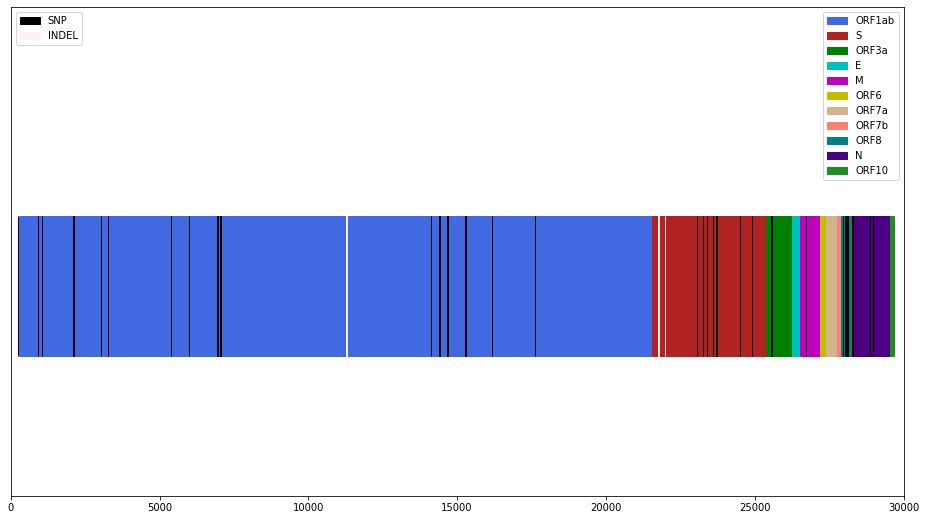

In [90]:
lst_color=['royalblue', 'firebrick', 'g', 'c', 'm', 'y', 'tan', 'salmon', 'teal', 'indigo', 'forestgreen']


plt.figure(figsize=(16, 9))
currentAxis = plt.gca()
for kl, iid in enumerate(dic_map.keys()):
    #print(iid)
    currentAxis.add_patch(Rectangle((dic_map[iid][0], 0.2), dic_map[iid][1]-dic_map[iid][0], 0.2, color=lst_color[kl], alpha=1))

for i in range(0, len(mut_df)):
  
    if mut_df.iloc[i]['type']=='snp':
        rec1=currentAxis.add_patch(Rectangle((mut_df.iloc[i]['position']-8, 0.2), 16, 0.2, color='k', alpha=1))
    elif mut_df.iloc[i]['type']=='indel':
        rec2=currentAxis.add_patch(Rectangle((mut_df.iloc[i]['position']-8, 0.2), 16, 0.2, color='lavenderblush', alpha=1))

        
plt.xlim([0, 30000])
plt.ylim([0, 0.7])

leg2=plt.legend([rec1, rec2], ['SNP', 'INDEL'], loc=2)
plt.legend(dic_map.keys(), loc=1)
plt.gca().add_artist(leg2)
currentAxis.axes.get_yaxis().set_visible(False)
plt.show()  

In [80]:
dir(plt.Axes)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_convert_dx',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_clipping_extent_bbox',
 '_get_view',
 '_init_axis',
 '_make_twin_axes',
 '_on_units_changed',
 '_parse_scatter_color_args',
 '_pcolorargs',
 '_process_unit_info',
 '_prop_order',
 '_quiver_units',
 '_remove_legend',
 '_sci',
 '_set_artist_props',
 '_set_gc_clip',
 '_set_lim_and_transforms',
 '_set_position',
 '_set_title_offset_trans',
 '_set_view',
 '_set_view_from_bbox',
 '_shared_x_axes',
 '_shared_y_axes',
 '_twinned_axes',
 '_update_image_limits',
 '_update_line_limits',
 '_update